(ref:lec4:ex2_sol)=
# Solutions of Exercise 4.2

```{figure} res/ex2.svg
---
height: 170
name: fig:lec4:ex2_sol
---
Block diagram of the DC-servomotor.
```

In {numref}`fig:lec4:ex2_sol` the block diagram of a DC-servomotor is illustrated. 

In this system, the input voltage $u$ first goes through a [isolated DC-DC convert](https://en.wikipedia.org/wiki/DC-to-DC_converter)[^dc-dc], which applies the desired voltage $u$ to the motor.
This converter is modeled by the first-order transfer function with time constant $T=10$ ms.

The voltage is then applied to the motor, described by a second order transfer function with gain $k_m=10$, electrical time constant $T_2 =25$ ms, and mechanical time constant $T_1 = 50$ ms.

The servomotor is first tested with $F(s) = 1$, but the closed-loop turns out to be too slow. 

1. Find $F(s) = K$ so thatthe closed-loop is twice as fast as for $F(s)=1$.
2. Then, find $K$ so that the following accuracy requirements are sastisfied:
   - When $\theta_{ref}(t) = \textrm{step}(t)$, at steady state $\lvert \theta -  \theta_{ref} \lvert \leq 0.001$
   - When $\theta_{ref}(t) = 10 \cdot \textrm{ramp}(t)$, at steady state $\lvert \theta(t) -  \theta_{ref}(t)  \lvert \leq 0.01$
3. **(Extra!)** Assume that the motor current can be measured. With the help of MATLAB, design a cascade control scheme for $G_2(s) = \frac{Z(s)}{U(s)} = \frac{1}{(1+sT)(1+sT_2)}$ and $G_1(s) = \frac{Y(s)}{Z(s)} = \frac{10}{s(1+sT_1)}$, so that the phase margin is at least $60^\circ$, and the bandwidth of the servomotr is at least $100$  rad/s.

---

## Solution

### Question 1

First of all, let's compute the bandwith for $F(s) = K = 1$. The open loop transfer function is defined as

$$
G_o(s) = F(s) G(s) = K \frac{10}{s(1+sT)(1+sT_1)(1+sT_2)}
$$ (eq:lec4:ex2:Go)

while the closed-loop transfer function is

$$
G_c(s) = \frac{G_o(s)}{1+G_o(s)} = \frac{10 K}{(T T_1 T_2)s^4 + (T T_1 + T T_2 + T_1 T_2) s^3 + (T+T_1+T_2 + T) s^2 + s + 10 K}
$$ (eq:lec4:ex2:Gc)

Finding $\omega_B$ such that $\lvert G_c(i \omega_B) \lvert = \frac{1}{\sqrt{2}}$ is impractical because of its high order.

Instead, we can sketch the Bode plot of $G_o(s)$ and compute the critical frequency $\omega_c \approx \omega_B$.

In [1]:
set(groot, 'defaultLineLineWidth', 2);

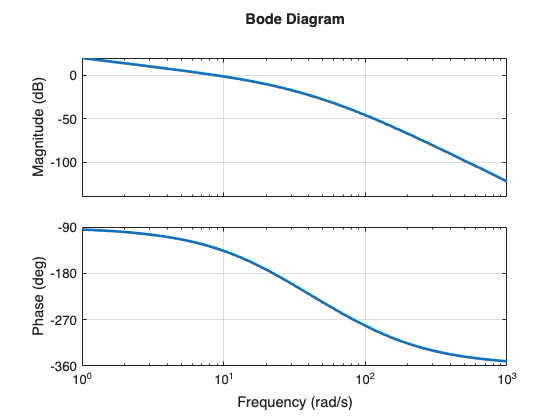

In [2]:
s = tf('s');
G = 10 / (s * (1 + 0.01*s) * (1 + 0.025*s) * (1 + 0.05*s));
figure;
bode(G, {1, 1000});
grid on;

The bandwidth for $K=1$ is approximately $9$ rad/s.

This means we are required to find $K$ such that the critical frequency is $18$ rad/s. Looking at the Bode plot of $G(s)$, we can see that $\lvert G(i 18) \lvert_{\text{dB}} \approx -8 $ dB. 


In [3]:
mag_at_18 =  mag2db(abs(freqresp(G, 18)));
disp(sprintf('Magnitude at 18 rad/s: %.1f dB', mag_at_18));

Magnitude at 18 rad/s: -8.6 dB


Therefore, taking $K = 8.6 \text{ dB } = 2.7$ we get an open-loop transfer function with critical frequency $\omega_c = 18$ rad/s

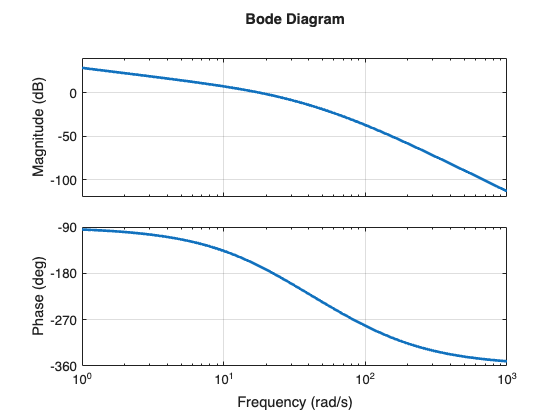

In [4]:
Go = 2.7 * G;
figure; 
bode(Go, {1, 1000});
grid on;

```{note}
Remember that $\omega_B$ is not exactly equal to the critical frequency $\omega_c$. It is just a useful approximation!
```

In [5]:
G_c = G / (1 + G); % Closed looop transfer function for K=1
[mag, ~, w] = bode(G_c, {1, 1000});
w_b = w(find(mag > 1/sqrt(2), 1, 'last'));
disp(sprintf('Closed-loop bandwidth for K=1 is %.2f rad/s, while the critical frequency is %.0f rad/s', w_b, 9));

G_c = Go / (1 + Go); % Closed looop transfer function for K=2.7
[mag, ~, w] = bode(G_c, {1, 1000});
w_b = w(find(mag > 1/sqrt(2), 1, 'last'));
disp(sprintf('Closed-loop bandwidth for K=2.7 is %.2f rad/s, while the critical frequency is %.0f rad/s', w_b, 18));

Closed-loop bandwidth for K=1 is 14.42 rad/s, while the critical frequency is 9 rad/s


Closed-loop bandwidth for K=2.7 is 28.45 rad/s, while the critical frequency is 18 rad/s


### Question 2

Consider the open-loop transfer function {eq}`eq:lec4:ex2:Go` and the closed-loop transfer function {eq}`eq:lec4:ex2:Gc` for a generic gain $K$.

We start by analyzing for what values of $K$ the closed-loop remains stable. For this, we can use root locus.

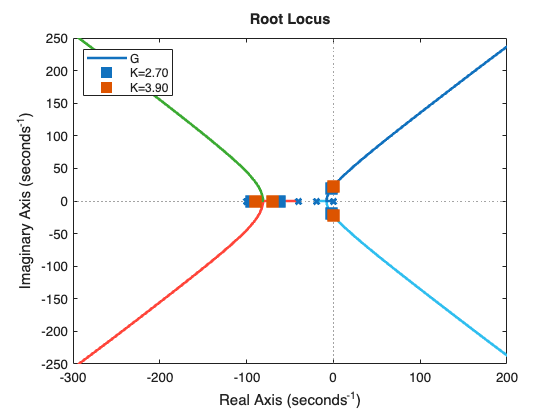

In [6]:
figure;
rlocus(G); hold on; % Plot the root locus

% Plot the closed-loop poles for specific values of K
K_points = [2.7, 3.9];
for k=K_points
    Gok = k * G;
    [num, den] = tfdata(Gok, "vector");
    poles = roots(num + den);
    p = plot(real(poles), imag(poles), 's', 'MarkerSize', 10, 'MarkerFaceColor', 'auto', 'DisplayName', sprintf('K=%.2f', k));
    set(p, 'markerfacecolor', get(p, 'color'));
end
legend('Location', 'northwest'); hold off;

The closed-loop is stable for $0 < K < 3.9$.

#### Error for step references
For step references, i.e.  $\theta_{ref}(t) = \textrm{step}(t)$, the steady-state tracking error is exactly $0$, provided that the closed loop is stable ($0 < K < 3.9$).
In fact, the type of $G_o(s)$ is $g=1$, because $G_o(s)$ has exactly one pole in $s=0$. 

#### Error for ramp references
When it comes to $\theta_{ref}(t) = 10 \cdot \textrm{ramp}(t)$, we can apply the Final Value Theorem

$$
e(t) = \lim_{s \to 0} s \big[ 1 - G_c(s)] \frac{10}{s^2} = \lim_{s \to 0} \frac{\cancel{s} + h.o.t.}{h.o.t. +  10 K} \frac{10}{\cancel{s}} = \frac{1}{K}
$$

In order to get the desired $1\%$ accuracy we would need $K> 100$, which unfortunately breaks the closed-loop stability assumption of the Final Value Theorem!

### Question 3

The solution will be provided over the next few weeks. 

**Hints:**
- Use PD controllers for both the outer and the inner control loop.
- Use the function `margin(Go)` to evaluate the phase and gain margin given the open loop transfer function `Go`
- Remember that the bandwidth of the inner loop must be at least $10\times$ larger than that of the outer loop.



[^dc-dc]: A DC-DC isolated converter is an electronic device that applies the desired control signal  $u$  to the motor while keeping the controller board electrically insulated from the high-current/high-voltage motor circuit.